<font size="6"> **DMBEM Project Gianluca**</font>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ZHAW-dm4bem-2023/reproducible-report-gianluca/HEAD)

# Introduction & Setup 

Das Gebäude, von welchem Teile simuliert werden sollen, befindet sich in Holzkirchen, Deutschland. Das Haus ist Teil einer Studie der Universität Strathclyde Glasgow welche sich mit der Energiemodellierung und Performance von Gebäuden auseinander setzt. So wurde im Jahr 2013 experimentelle Daten gesammelt, um eine Validierung der computerbasierten Modelle zu ermöglichen. Um hochwertige Daten generieren zu können, wurde ein zweites, identisches Haus gebaut, welches nach Überprüfung sich weniger als 5 % vom ersten sogeannten "Zwillingshaus" unterschied.

Diese Daten werden nun auch in diesem Projekt verwendet, um eine Aussage über die Qualität des hier bestehenden Modelles zu machen. 

Alle Daten, welche hier zur Anwendung kommen, wurden von der Studie: "Twin Houses Empirical Dataset: Experiment 1" entnommen (Quelle: [Dataset]).

[Dataset]: https://pureportal.strath.ac.uk/en/datasets/twin-houses-empirical-dataset-experiment-1

## Building 

Auf den folgenden Bildern Fig. 1 & 2 ist das Setup, die Lage und Ausrichtung der Zwillingshäuser zu erkennen.  

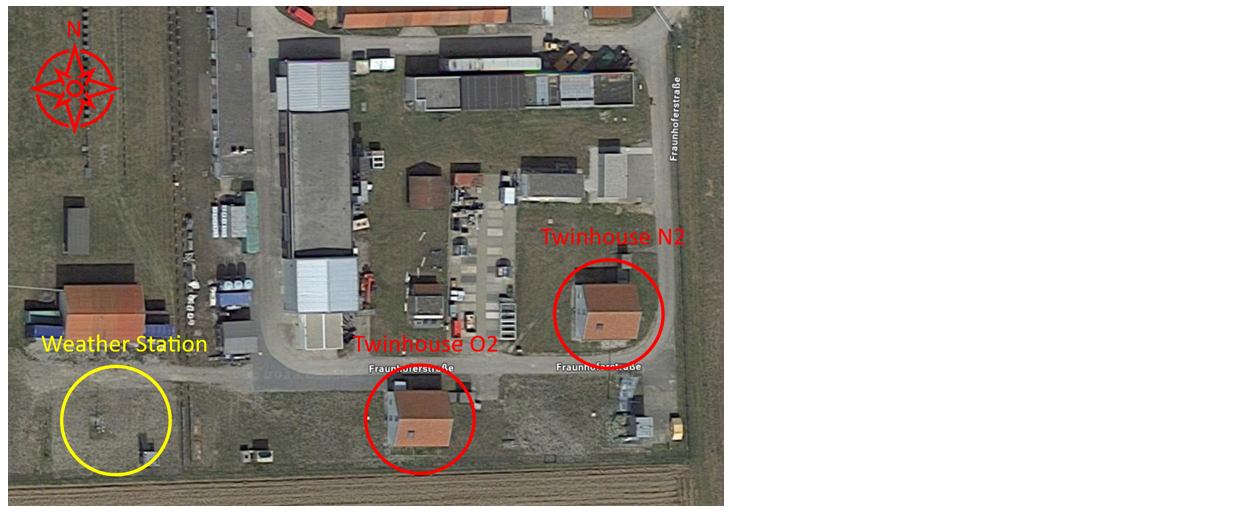
*Fig.1: The twin houses are located at [Holzkirchen] and are connected to a local weather station*

[Holzkirchen]: https://www.google.ch/maps/place/Fraunhofer-Institut+f%C3%BCr+Bauphysik+IBP/@47.8754298,11.7268692,322m/data=!3m1!1e3!4m6!3m5!1s0x479deddfcb23363b:0xd311a8c2b01ec930!8m2!3d47.8755984!4d11.7280582!16s%2Fg%2F1tf7r3ct?hl=de&entry=ttu

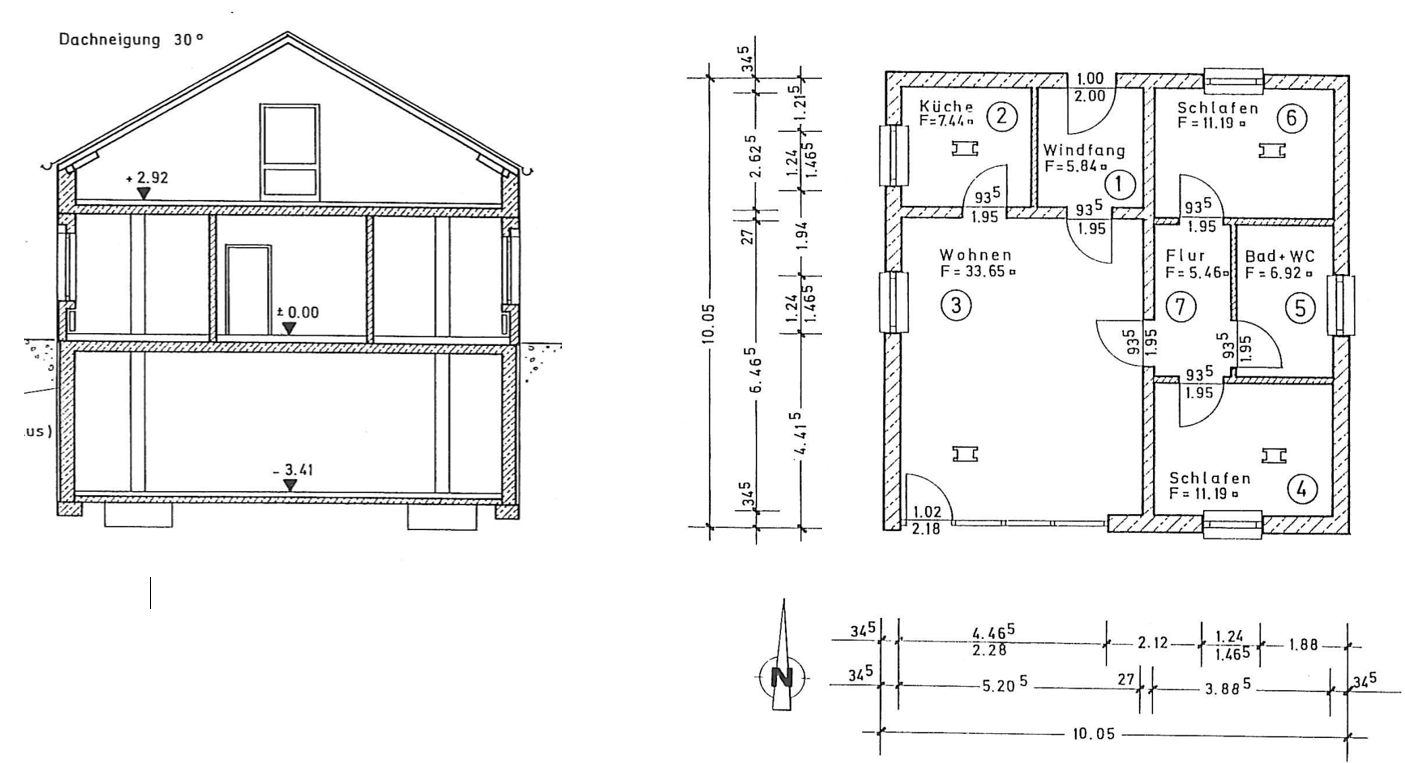
*Fig.2: Plan and Cross Section of the Twin House*

# Model 

## Model description

Das in diesen Projekt erstellte befasst sich mit der Westwand des Zwillingshauses "N2". Als Input wurden die Lufttemperaturen Aussen To und Innen Ti sowie die gesamthafte Strahlung von Westen Etot verwendet. Als Outputparameter wurden die Oberflächentemperaturen Aussen To_sur und Innen Ti_sur sowie eine Temperatur in der Wand definiert. Alle genannten Input- und Outputparameter wurden deshalb gewählt, da diese bei den Messungen 2013 erfasst wurden und so so möglich ist, das Modell mit den experimentellen Daten zu validieren. 

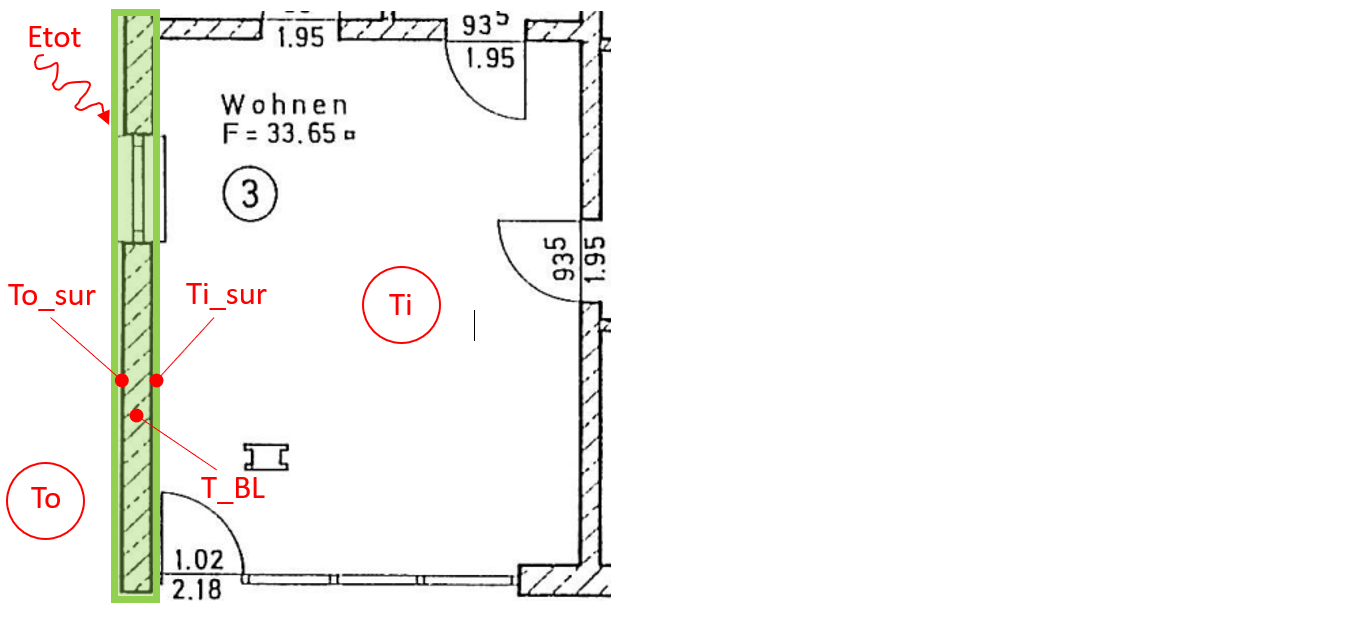
*Fig.3: Grün markiert ist ist die modellierte Wand mit allen Input und Outputparametern zu erkennen*

## Thermal network  

Das oben beschriebene Modell soll in einer Messperiode überprüft werden, in welcher die Rollos der Fenster geschlossen sind. Aus diesem Grund hat man die Wand vereinfacht dargestellt und auf die Modellierung des Fensters verzichtet. 
Eine weitere Vereinfachung beinhaltet die verschiedenen Schichten der Wand. Man hat sich entschieden, aus 5 ursprünglichen Schichten, sich auf zwei Schichten zu begrenzen. Dies, da einige Schichten sehr dünn sind und deshalb vernachlässigt werden können. Entsprechend wichtige Charakteristiken der vernachlässigen Wände wie beispielsweise Absorptions- oder Emissionskoeffizient wurden auf die bestehenden Schichten übernommen. 

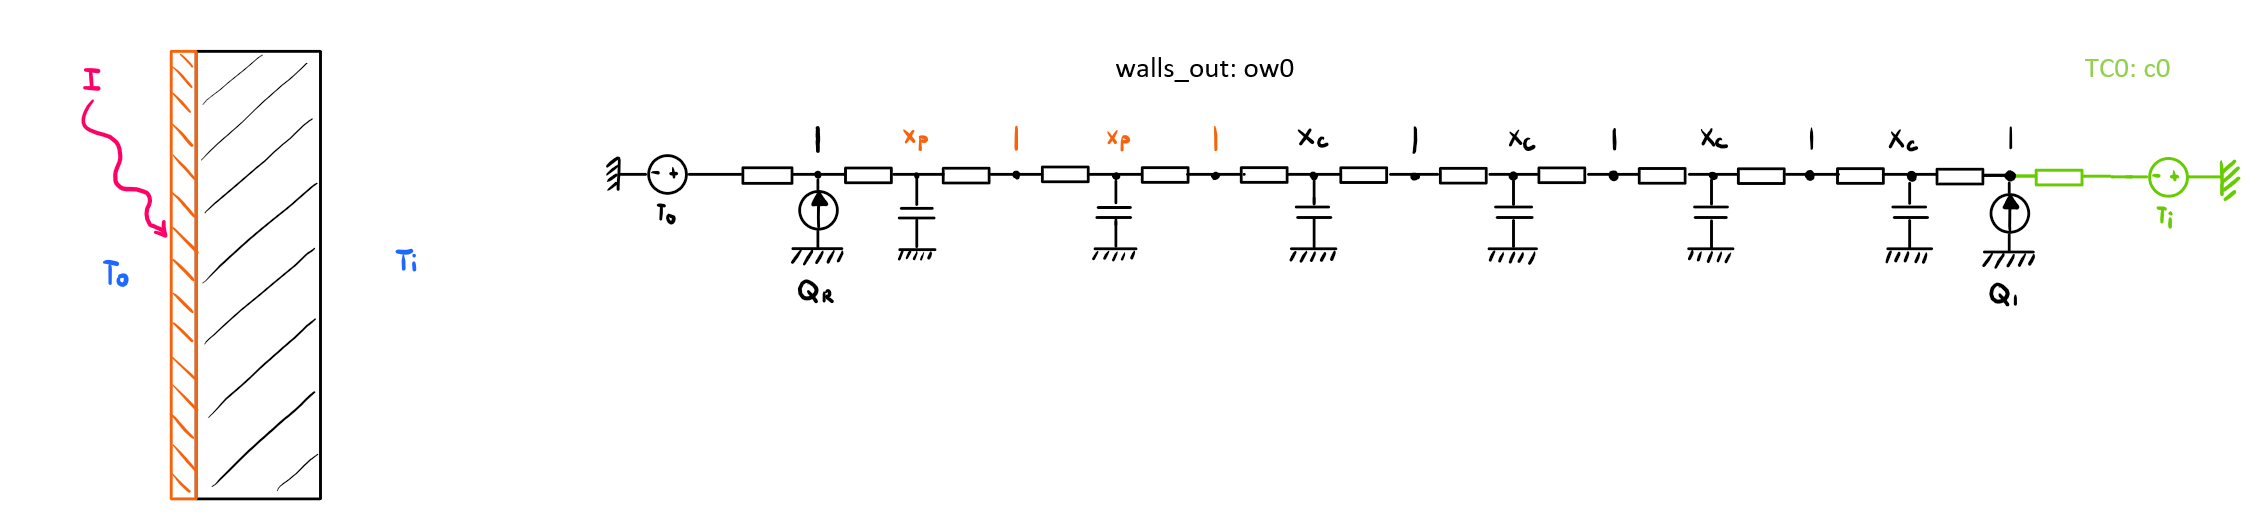
*Fig.4: Simplified wall with the according assembled thermal circuit*

Auf der rechten Seite von Figure 4 kann man die vereinfachte Wand erkennen. Auf der linken Seite ist der thermische Kreislauf bestehend aus zwei einzelnen TC's abgebildet. Diese wurden mit einer Assembly list zusammengesetzt.

## Wall & Material characteristics 

### Wall characteristics

**Wall Area:** 14.33 m<sup>2</sup>

**Tilt angle:** 90 °

**<span style="color:orange">Insulation:</span>**

<span style="color:orange">- Conductivity: 0.04 (W/(m⋅K))</span>

<span style="color:orange">- Specific heat: 840 J/(kg⋅K)</span>

<span style="color:orange">- Density: 80 kg/m<sup>3</sup></span>

<span style="color:orange">- Width: 0.1 m</span>

<span style="color:orange">- Mesh: 4</span>


**Honeycomb Brick:**

- Conductivity: 0.22 (W/(m⋅K))

- Specific heat: 1000 J/(kg⋅K)

- Density: 800 kg/m<sup>3</sup>

- Width: 0.32 m

- Mesh: 14


### Material characteristics 

Convection coefficient on outer surface **h0**: 18 W/(m<sup>2</sup>⋅K)

Convection coefficient on inner surface **h1**: 7 W/(m<sup>2</sup>⋅K)

Short-wave absorbtion coefficient of outer surface **α0**: 0.17 

Long-wave hemispherical emissivity of outer surface **ε0**: 0.9 

The values for these properties were taken from Incropera et al. (2011) Fundamentals of heat and mass transfer, 7 ed, Table A3, and the Engineering Toolbox (https://www.engineeringtoolbox.com).


In [1]:
import pandas as pd
import dm4bem
import numpy as np
import matplotlib.pyplot as plt

In [1]:
Input_data = pd.read_csv('Input_Data.csv', index_col=0, usecols=['Index','To','Etot','Qi','Ti'], sep=';')

Validation_data = pd.read_csv('Validation_Data.csv', index_col=0, usecols=['Index','To_sur','To_sur_low','To_sur_high','Ti_sur','Ti_sur_low','Ti_sur_high','T_BL','T_BL_low','T_BL_high'], sep=';')

wall_types = pd.read_csv('wall_types.csv')

walls = pd.read_csv('walls_out.csv')

## Thermal Circuit to State-Space representation

In [2]:
TCd = dm4bem.bldg2TCd('',
                      TC_auto_number=True)

ass_lists = pd.read_csv('assembly_lists.csv',sep=';')
ass_mat = dm4bem.assemble_lists2matrix(ass_lists)
TC = dm4bem.assemble_TCd_matrix(TCd, ass_mat)

# State-space from TC
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As


dtmax = 2 * min(-1. / λ) # max time step for Euler explicit stability
print(f'\nMaximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

dt = dm4bem.round_time(dtmax)
dm4bem.print_rounded_time('dt', dt)

### Time step & Settling Time

In [2]:
t_settle = 4 * max(-1. / λ)
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)


Maximum time step: 541.86 s = 9.03 min
dt = 300 s = 5.0 min
duration = 579600 s = 161.0 h


# Simulation 

## Steady State Solution 

<Axes: >

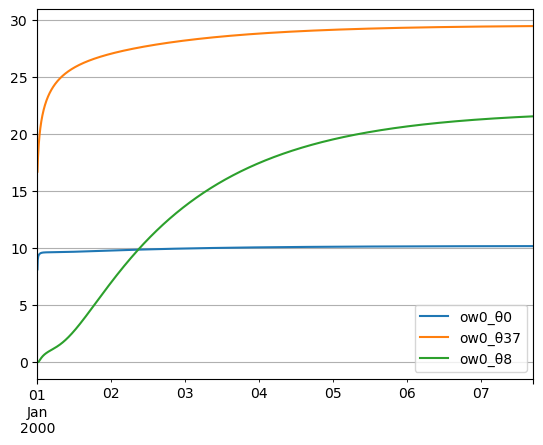

In [3]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                     periods=n, freq=f"{int(dt)}S")

To_SS = Input_data.iloc[0]['To'] * np.ones(n)
Ti_SS = Input_data.iloc[0]['Ti'] * np.ones(n)
Qo_SS = Input_data.iloc[0]['Etot']*walls['α1'].values[0]*walls['Area'].values[0] * np.ones(n)
Qi_SS = 0* np.ones(n)

data_SS = {'To': To_SS, 'Ti': Ti_SS, 'Qo': Qo_SS, 'Qi': Qi_SS}
input_data_set_SS = pd.DataFrame(data_SS, index=time)

# Get input u from input_data_set
u_SS = dm4bem.inputs_in_time(us, input_data_set_SS)

# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u_SS.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0


I = np.eye(As.shape[0])     # identity matrix

for k in range(n - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u_SS.iloc[k]

        
# Outputs
y_SS = (Cs @ θ_exp.T + Ds @  u_SS.T).T

# Plot
y_SS.plot(kind='line', marker='', linestyle='-', label=['Explicit'], grid=True)

## Transient solution with weather data

Input of To, Ti and E_tot all 10 mins. Als Initiallösung wurde die Lösung der Steady State Rechnungen verwendet. 

In [4]:
# Input
To = Input_data['To']
Ti = Input_data['Ti']

Etot = Input_data['Etot']
Qo = walls['α1'].values[0]*walls['Area'].values[0]*Etot
Qi = Input_data['Qi']


# Input data set
input_data_set = pd.DataFrame({'To': To, 'Qo': Qo, 'Ti': Ti,  'Qi': Qi})


# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)


# Initial conditions
θ0_trans = θ_exp.iloc[-1]                 # initial temperatures
θ_exp_trans = pd.DataFrame(index=u.index)
θ_exp_trans[As.columns] = θ0_trans      # Fill θ with initial valeus θ0

# time integration
I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp_trans.iloc[k + 1] = (I + dt * As)\
        @ θ_exp_trans.iloc[k] + dt * Bs @ u.iloc[k]

# Outputs
y = (Cs @ θ_exp_trans.T + Ds @  u.T).T

## Results

Gitterunabhängigkeit 

Parameter, welche starken Einfluss haben



### Outer Surface 

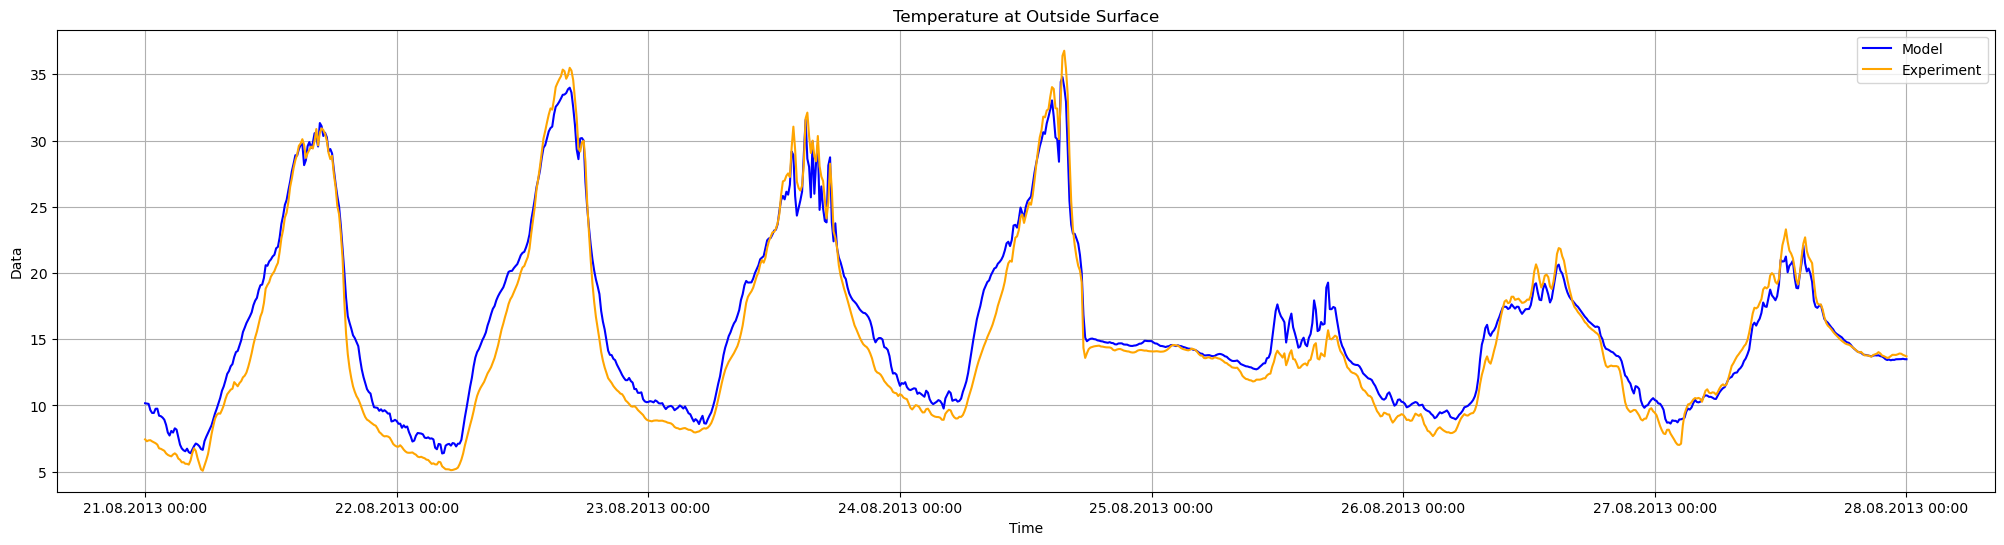

In [5]:
# Plot
data = pd.DataFrame({'Model': y['ow0_θ0'],
                     'Experiment': Validation_data['To_sur']})

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(data.index, data['Model'], label='Model', color='blue')
ax.plot(data.index, data['Experiment'], label='Experiment',color='orange')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Data')
ax.set_title('Temperature at Outside Surface')
ax.set_xticks(data.index[::144])
ax.grid(True)

### Inner Surface 

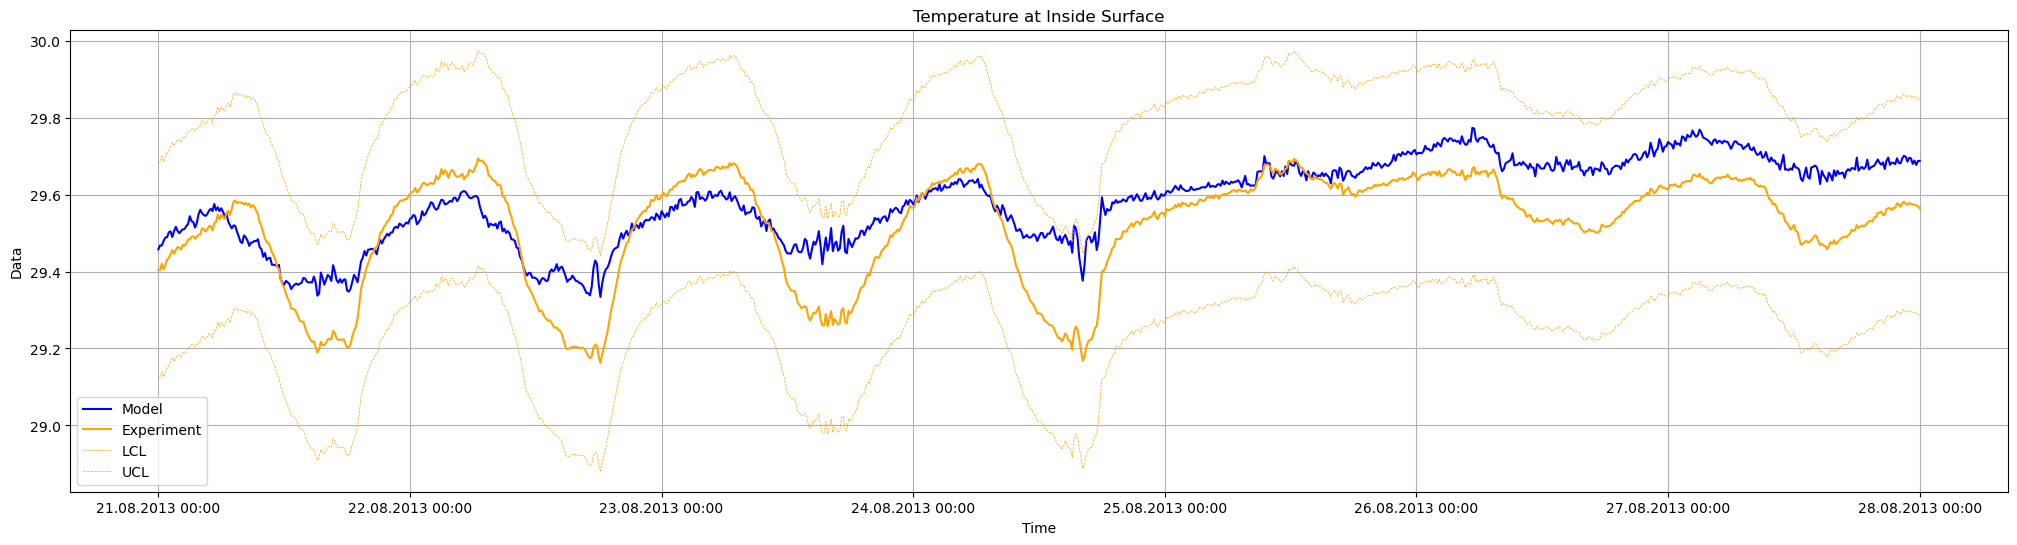

In [6]:
# Plot
data = pd.DataFrame({'Model': y['ow0_θ37'],
                     'Experiment': Validation_data['Ti_sur'],
                     'LCL': Validation_data['Ti_sur_low'],
                     'UCL': Validation_data['Ti_sur_high']})

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(data.index, data['Model'], label='Model', color='blue')
ax.plot(data.index, data['Experiment'], label='Experiment',color='orange')
ax.plot(data.index, data['LCL'], label = 'LCL', linestyle='--', color='orange', lw=0.5)
ax.plot(data.index, data['UCL'], label = 'UCL', linestyle='--',color='orange', lw=0.5)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Data')
ax.set_title('Temperature at Inside Surface')
ax.set_xticks(data.index[::144])
ax.grid(True)

### Between Layer 

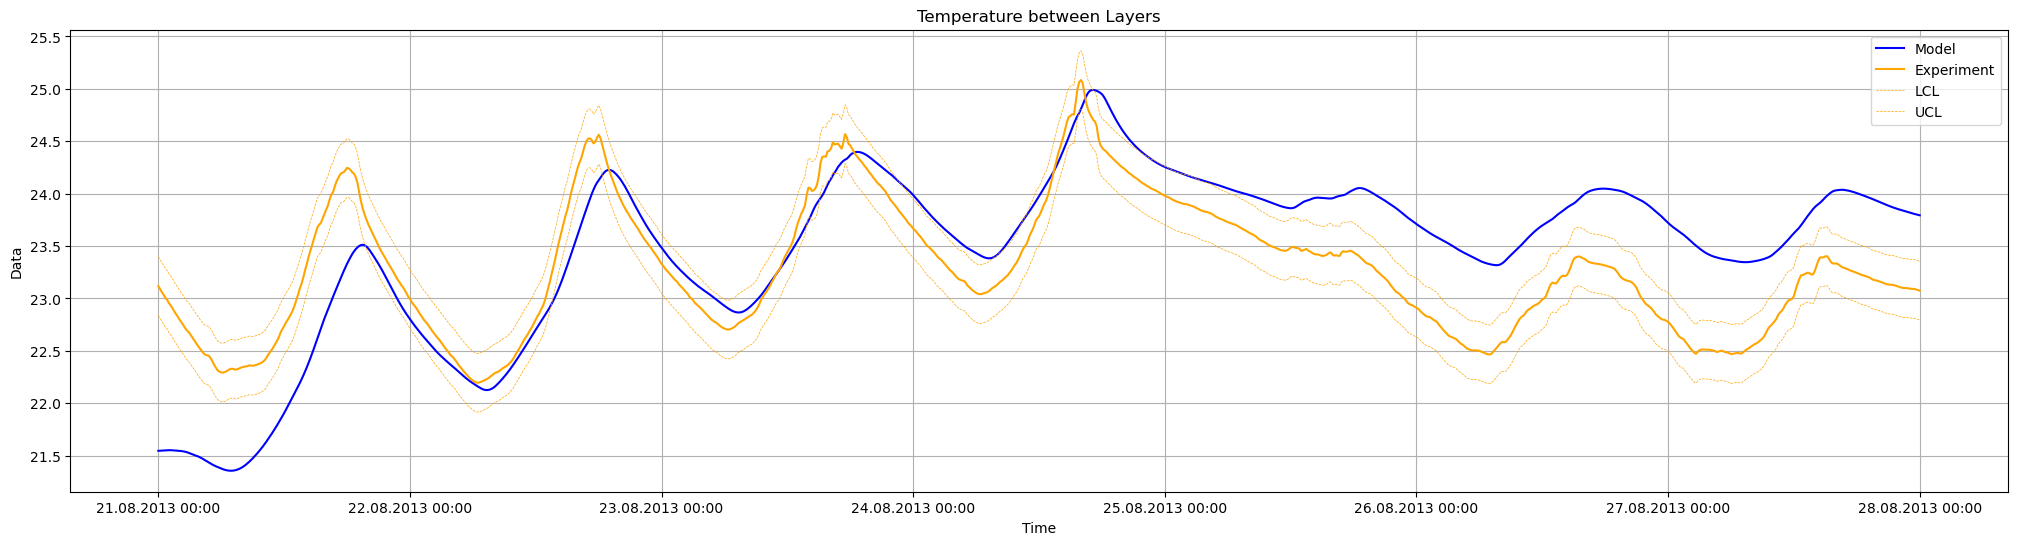

In [7]:
# Plot
data = pd.DataFrame({'Model': y['ow0_θ8'],
                     'Experiment': Validation_data['T_BL'],
                     'LCL': Validation_data['T_BL_low'],
                     'UCL': Validation_data['T_BL_high']})

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(data.index, data['Model'], label='Model', color='blue')
ax.plot(data.index, data['Experiment'], label='Experiment',color='orange')
ax.plot(data.index, data['LCL'], label = 'LCL', linestyle='--',color='orange',lw=0.5)
ax.plot(data.index, data['UCL'], label = 'UCL', linestyle='--',color='orange',lw=0.5)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Data')
ax.set_title('Temperature between Layers')
ax.set_xticks(data.index[::144])
ax.grid(True)

Eifach nur super 

## Conclusion

